In [2]:
from PIL import Image, ImageFilter
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import tempfile
import threading
import multiprocessing as mp
import io
import pickle

using already cropped files
{'.jpg'}
{(2000, 2000)}
Categories ['everyday', 'nature', 'text', 'night']


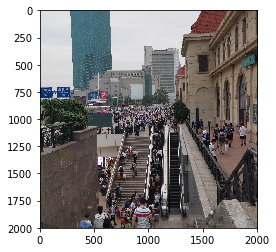

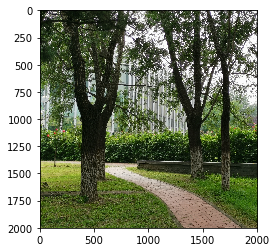

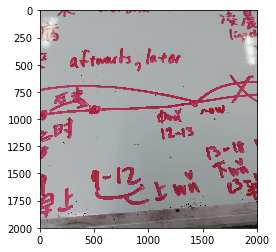

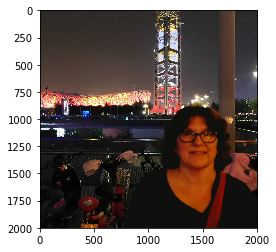

In [3]:
def read_images(photo_dir, crop=False):
    img_names = set()
    img_ext = set()
    img_sz = set()
    org_img_sz = set()
    imgs = dict()
    for subdir in Path(photo_dir).glob("*"):
        imgs[str(subdir.stem)] = list()
        for photo in Path(subdir).glob("*"):
            if str(photo) in img_names:
                print("error repeated file")
            else:
                img_names.add(str(photo))
            img_ext.add(str(photo.suffix))
            img = Image.open(photo)
            sz = img.size
            org_img_sz.add(sz)
            if crop:
                box_sz = 1000
                img = img.crop([
                    int(sz[0]/2) - box_sz, # left
                    int(sz[1]/2) - box_sz, # upper
                    int(sz[0]/2) + box_sz, # right
                    int(sz[1]/2) + box_sz, # lower
                ])
            img_sz.add(img.size)
            imgs[str(subdir.stem)].append({
                "img": img,
                "filename": photo.name,
                "size": photo.stat().st_size,
            })
    print(img_ext)
    print(img_sz)
    return imgs

cropped_dir = Path("/home/austin/research/sp2_am/photos/cropped")
if not cropped_dir.exists():
    print("creating new cropped files")
    images = read_images("/home/austin/research/sp2_am/photos/", crop=True)
    Path(cropped_dir).mkdir()
    for cat_dir, data in images.items():
        Path(cropped_dir/Path(cat_dir)).mkdir()
        for img in data:
            img["img"].save(
                cropped_dir/Path(cat_dir)/Path(img["filename"]),
                quality = 95
            )
    print('done...')
else:
    print("using already cropped files")
    images = read_images(cropped_dir)
    print("Categories", list(images.keys()))
    plt.imshow(images['everyday'][0]["img"])
    plt.show()
    plt.imshow(images['nature'][0]["img"])
    plt.show()
    plt.imshow(images['text'][0]["img"])
    plt.show()
    plt.imshow(images['night'][0]["img"])
    plt.show()

In [3]:
images['nature'][0]['size']/1024/1024

1.9847917556762695

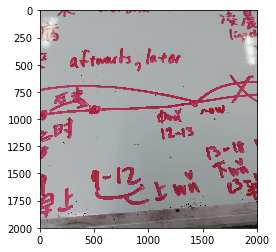

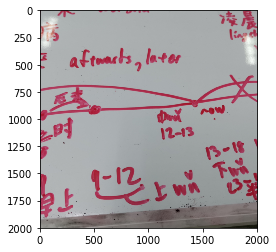

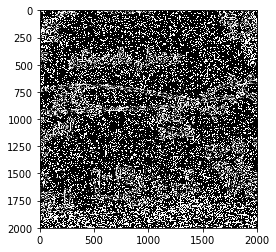

In [3]:
fil = ImageFilter.GaussianBlur()
plt.imshow(images['text'][0]["img"])
plt.show()
plt.imshow(images['text'][0]["img"].filter(fil))
plt.show()
diffs = np.array(images['text'][0]["img"].filter(fil)) - np.array(images['text'][0]['img'])
temp = np.zeros([2000,2000,3], dtype=int)
for i in range(0,2000):
    for j in range(0,2000):
        mag = float(diffs[i,j,0]) + float(diffs[i,j,1]) + float(diffs[i,j,2])
        mag = mag / 3.0
        temp[i,j,0] = int(mag)
        temp[i,j,1] = int(mag)
        temp[i,j,2] = int(mag)
diffs = np.array(temp)
plt.imshow(diffs)
plt.show()

In [3]:
def mse(base_img, dist_img):
    return np.sum(
        np.power(
            np.absolute(base_img - dist_img),2)
    )/(base_img.shape[0]*base_img.shape[1])
def max_f(img):
    return np.max(img)
def psnr(base_img, dist_img):
    base_img = np.array(base_img)
    dist_img = np.array(dist_img)
    mse_r = mse(base_img[:,:,0], dist_img[:,:,0])
    mse_g = mse(base_img[:,:,1], dist_img[:,:,1])
    mse_b = mse(base_img[:,:,2], dist_img[:,:,2])
    mse_all = (mse_r + mse_g + mse_b)/3.0
    return 20*np.log10((max_f(base_img)/np.sqrt(mse_all)))

In [5]:
print(psnr(np.array(images['text'][0]['img']), np.array(images['text'][0]['img'].filter(fil))))
print(psnr(np.array(images['text'][0]['img']), np.array(images['text'][0]['img'])))

38.69109104146269
inf


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


In [4]:
filters = [
    {
        "name": "Gaussian Blur",
        "sizes": [i for i in range(2, 32 + 1)], #1-14
        "constructor": ImageFilter.GaussianBlur
    },
    {
    "name": "Box Blur",
        "sizes": [i for i in range(2, 32 + 1)], #1-14
        "constructor": ImageFilter.BoxBlur
    },
    {
        "name": "Median Filter",
        "sizes": [i for i in range(2, 32 + 1)], #1-14
        "constructor": ImageFilter.MedianFilter
    },
    {
        "name": "Min Filter",
        "sizes": [i for i in range(2, 32 + 1)], #1-14
        "constructor": ImageFilter.MinFilter
    },
    {
        "name": "Max Filter",
        "sizes": [i for i in range(2, 32 + 1)], #1-14
        "constructor": ImageFilter.MaxFilter
    },
    {
        "name": "Mode Filter",
        "sizes": [i for i in range(2, 32 + 1)], #1-14
        "constructor": ImageFilter.ModeFilter
    },
]

ctx = mp.get_context('fork')
res = {}
for fil in filters:
    res[fil['name']] = {}
    for cat, imgs in images.items():
        res[fil['name']][cat] = {}
        threads = []
        conns = []
        def fill_data():
            i = 0
            for img in imgs:
                #res[fil['name']][cat][img['filename']] = {
                #        'sizes': [],
                #        'org_sz': [],
                #        'new_sz': [],
                #        'psnr': [],
                #}

                #table = res[fil['name']][cat][img['filename']]
                table = {
                    'sizes': [],
                    'org_sz': [],
                    'new_sz': [],
                    'psnr': [],
                    'org_bitperpx': [],
                    'new_bitperpx': [],
                }
                for size in fil['sizes']:
                    try:
                        fil_img = img['img'].filter(fil['constructor'](size))
                    except ValueError:
                        # becuase bad filter sizes of unknown size
                        print("Continuing on size {} for filter {}", size, fil['name'])
                        continue
                        
                    table['psnr'].append(psnr(img['img'], fil_img))

                    #tfile, tpath = tempfile.mkstemp()
                    #tfile2 = os.fdopen(tfile)
                    tfile2 = io.BytesIO()
                    fil_img.save(tfile2, format='JPEG', quality=95)
                    tfile2_sz = len(tfile2.getvalue())
                    table['sizes'].append(size)
                    table['org_sz'].append(img['size'])
                    table['new_sz'].append(tfile2_sz)
                    table['org_bitperpx'].append(
                        (8*table['org_sz'][-1])/(img['img'].height*img['img'].width))
                    table['new_bitperpx'].append(
                        (8*table['new_sz'][-1])/(fil_img.height*fil_img.width))
                    tfile2.close()
                    #os.remove(tpath)

                    del fil_img

                    #plt.imshow(fil_img)
                    #plt.show()
                res[fil['name']][cat][img['filename']] = table
                if i == 4:
                    pass
                else:
                    i+=1
        thread = threading.Thread(target=fill_data)
        thread.start()
        threads.append(thread)
        for t in threads:
            t.join()
        print('one iteration')

one iteration
one iteration
one iteration
one iteration
one iteration
one iteration
one iteration
one iteration
Continuing on size {} for filter {} 2 Median Filter
Continuing on size {} for filter {} 4 Median Filter
Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter
Continuing on size {} for filter {} 12 Median Filter
Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filter
Continuing on size {} for filter {} 20 Median Filter
Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filter
Continuing on size {} for filter {} 28 Median Filter
Continuing on size {} for filter {} 30 Median Filter
Continuing on size {} for filter {} 32 Median Filter
Continuing on size {} for filter {} 2 Median

Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filter
Continuing on size {} for filter {} 28 Median Filter
Continuing on size {} for filter {} 30 Median Filter
Continuing on size {} for filter {} 32 Median Filter
Continuing on size {} for filter {} 2 Median Filter
Continuing on size {} for filter {} 4 Median Filter
Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter
Continuing on size {} for filter {} 12 Median Filter
Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filter
Continuing on size {} for filter {} 20 Median Filter
Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filt

Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filter
Continuing on size {} for filter {} 20 Median Filter
Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filter
Continuing on size {} for filter {} 28 Median Filter
Continuing on size {} for filter {} 30 Median Filter
Continuing on size {} for filter {} 32 Median Filter
Continuing on size {} for filter {} 2 Median Filter
Continuing on size {} for filter {} 4 Median Filter
Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter
Continuing on size {} for filter {} 12 Median Filter
Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filt

Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter
Continuing on size {} for filter {} 12 Median Filter
Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filter
Continuing on size {} for filter {} 20 Median Filter
Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filter
Continuing on size {} for filter {} 28 Median Filter
Continuing on size {} for filter {} 30 Median Filter
Continuing on size {} for filter {} 32 Median Filter
Continuing on size {} for filter {} 2 Median Filter
Continuing on size {} for filter {} 4 Median Filter
Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter

Continuing on size {} for filter {} 30 Median Filter
Continuing on size {} for filter {} 32 Median Filter
Continuing on size {} for filter {} 2 Median Filter
Continuing on size {} for filter {} 4 Median Filter
Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter
Continuing on size {} for filter {} 12 Median Filter
Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filter
Continuing on size {} for filter {} 20 Median Filter
Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filter
Continuing on size {} for filter {} 28 Median Filter
Continuing on size {} for filter {} 30 Median Filter
Continuing on size {} for filter {} 32 Median Filter
Continuing on size {} for filter {} 2 Median Filte

Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filter
Continuing on size {} for filter {} 28 Median Filter
Continuing on size {} for filter {} 30 Median Filter
Continuing on size {} for filter {} 32 Median Filter
Continuing on size {} for filter {} 2 Median Filter
Continuing on size {} for filter {} 4 Median Filter
Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter
Continuing on size {} for filter {} 12 Median Filter
Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filter
Continuing on size {} for filter {} 20 Median Filter
Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filt

Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filter
Continuing on size {} for filter {} 20 Median Filter
Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filter
Continuing on size {} for filter {} 28 Median Filter
Continuing on size {} for filter {} 30 Median Filter
Continuing on size {} for filter {} 32 Median Filter
Continuing on size {} for filter {} 2 Median Filter
Continuing on size {} for filter {} 4 Median Filter
Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter
Continuing on size {} for filter {} 12 Median Filter
Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filt

Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter
Continuing on size {} for filter {} 12 Median Filter
Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filter
Continuing on size {} for filter {} 20 Median Filter
Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filter
Continuing on size {} for filter {} 28 Median Filter
Continuing on size {} for filter {} 30 Median Filter
Continuing on size {} for filter {} 32 Median Filter
Continuing on size {} for filter {} 2 Median Filter
Continuing on size {} for filter {} 4 Median Filter
Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter

Continuing on size {} for filter {} 30 Median Filter
Continuing on size {} for filter {} 32 Median Filter
Continuing on size {} for filter {} 2 Median Filter
Continuing on size {} for filter {} 4 Median Filter
Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter
Continuing on size {} for filter {} 12 Median Filter
Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filter
Continuing on size {} for filter {} 20 Median Filter
Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filter
Continuing on size {} for filter {} 28 Median Filter
Continuing on size {} for filter {} 30 Median Filter
Continuing on size {} for filter {} 32 Median Filter
Continuing on size {} for filter {} 2 Median Filte

Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filter
Continuing on size {} for filter {} 28 Median Filter
Continuing on size {} for filter {} 30 Median Filter
Continuing on size {} for filter {} 32 Median Filter
Continuing on size {} for filter {} 2 Median Filter
Continuing on size {} for filter {} 4 Median Filter
Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter
Continuing on size {} for filter {} 12 Median Filter
Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filter
Continuing on size {} for filter {} 20 Median Filter
Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filt

Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filter
Continuing on size {} for filter {} 20 Median Filter
Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filter
Continuing on size {} for filter {} 28 Median Filter
Continuing on size {} for filter {} 30 Median Filter
Continuing on size {} for filter {} 32 Median Filter
Continuing on size {} for filter {} 2 Median Filter
Continuing on size {} for filter {} 4 Median Filter
Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter
Continuing on size {} for filter {} 12 Median Filter
Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filt

Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter
Continuing on size {} for filter {} 12 Median Filter
Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filter
Continuing on size {} for filter {} 20 Median Filter
Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filter
Continuing on size {} for filter {} 28 Median Filter
Continuing on size {} for filter {} 30 Median Filter
Continuing on size {} for filter {} 32 Median Filter
Continuing on size {} for filter {} 2 Median Filter
Continuing on size {} for filter {} 4 Median Filter
Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter

Continuing on size {} for filter {} 30 Median Filter
Continuing on size {} for filter {} 32 Median Filter
Continuing on size {} for filter {} 2 Median Filter
Continuing on size {} for filter {} 4 Median Filter
Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter
Continuing on size {} for filter {} 12 Median Filter
Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filter
Continuing on size {} for filter {} 20 Median Filter
Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filter
Continuing on size {} for filter {} 28 Median Filter
Continuing on size {} for filter {} 30 Median Filter
Continuing on size {} for filter {} 32 Median Filter
Continuing on size {} for filter {} 2 Median Filte

Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filter
Continuing on size {} for filter {} 28 Median Filter
Continuing on size {} for filter {} 30 Median Filter
Continuing on size {} for filter {} 32 Median Filter
Continuing on size {} for filter {} 2 Median Filter
Continuing on size {} for filter {} 4 Median Filter
Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter
Continuing on size {} for filter {} 12 Median Filter
Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filter
Continuing on size {} for filter {} 20 Median Filter
Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filt

Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filter
Continuing on size {} for filter {} 20 Median Filter
Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filter
Continuing on size {} for filter {} 28 Median Filter
Continuing on size {} for filter {} 30 Median Filter
Continuing on size {} for filter {} 32 Median Filter
Continuing on size {} for filter {} 2 Median Filter
Continuing on size {} for filter {} 4 Median Filter
Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter
Continuing on size {} for filter {} 12 Median Filter
Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filt

Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter
Continuing on size {} for filter {} 12 Median Filter
Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filter
Continuing on size {} for filter {} 20 Median Filter
Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filter
Continuing on size {} for filter {} 28 Median Filter
Continuing on size {} for filter {} 30 Median Filter
Continuing on size {} for filter {} 32 Median Filter
Continuing on size {} for filter {} 2 Median Filter
Continuing on size {} for filter {} 4 Median Filter
Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter

Continuing on size {} for filter {} 30 Median Filter
Continuing on size {} for filter {} 32 Median Filter
Continuing on size {} for filter {} 2 Median Filter
Continuing on size {} for filter {} 4 Median Filter
Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter
Continuing on size {} for filter {} 12 Median Filter
Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filter
Continuing on size {} for filter {} 20 Median Filter
Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filter
Continuing on size {} for filter {} 28 Median Filter
Continuing on size {} for filter {} 30 Median Filter
Continuing on size {} for filter {} 32 Median Filter
Continuing on size {} for filter {} 2 Median Filte

Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filter
Continuing on size {} for filter {} 28 Median Filter
Continuing on size {} for filter {} 30 Median Filter
Continuing on size {} for filter {} 32 Median Filter
Continuing on size {} for filter {} 2 Median Filter
Continuing on size {} for filter {} 4 Median Filter
Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter
Continuing on size {} for filter {} 12 Median Filter
Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filter
Continuing on size {} for filter {} 20 Median Filter
Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filt

Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filter
Continuing on size {} for filter {} 20 Median Filter
Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filter
Continuing on size {} for filter {} 28 Median Filter
Continuing on size {} for filter {} 30 Median Filter
Continuing on size {} for filter {} 32 Median Filter
Continuing on size {} for filter {} 2 Median Filter
Continuing on size {} for filter {} 4 Median Filter
Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter
Continuing on size {} for filter {} 12 Median Filter
Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filt

Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter
Continuing on size {} for filter {} 12 Median Filter
Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filter
Continuing on size {} for filter {} 20 Median Filter
Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filter
Continuing on size {} for filter {} 28 Median Filter
Continuing on size {} for filter {} 30 Median Filter
Continuing on size {} for filter {} 32 Median Filter
Continuing on size {} for filter {} 2 Median Filter
Continuing on size {} for filter {} 4 Median Filter
Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter

Continuing on size {} for filter {} 30 Median Filter
Continuing on size {} for filter {} 32 Median Filter
Continuing on size {} for filter {} 2 Median Filter
Continuing on size {} for filter {} 4 Median Filter
Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter
Continuing on size {} for filter {} 12 Median Filter
Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filter
Continuing on size {} for filter {} 20 Median Filter
Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filter
Continuing on size {} for filter {} 28 Median Filter
Continuing on size {} for filter {} 30 Median Filter
Continuing on size {} for filter {} 32 Median Filter
Continuing on size {} for filter {} 2 Median Filte

Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filter
Continuing on size {} for filter {} 28 Median Filter
Continuing on size {} for filter {} 30 Median Filter
Continuing on size {} for filter {} 32 Median Filter
Continuing on size {} for filter {} 2 Median Filter
Continuing on size {} for filter {} 4 Median Filter
Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter
Continuing on size {} for filter {} 12 Median Filter
Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filter
Continuing on size {} for filter {} 20 Median Filter
Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filt

Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filter
Continuing on size {} for filter {} 20 Median Filter
Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filter
Continuing on size {} for filter {} 28 Median Filter
Continuing on size {} for filter {} 30 Median Filter
Continuing on size {} for filter {} 32 Median Filter
Continuing on size {} for filter {} 2 Median Filter
Continuing on size {} for filter {} 4 Median Filter
Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter
Continuing on size {} for filter {} 12 Median Filter
Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filt

Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter
Continuing on size {} for filter {} 12 Median Filter
Continuing on size {} for filter {} 14 Median Filter
Continuing on size {} for filter {} 16 Median Filter
Continuing on size {} for filter {} 18 Median Filter
Continuing on size {} for filter {} 20 Median Filter
Continuing on size {} for filter {} 22 Median Filter
Continuing on size {} for filter {} 24 Median Filter
Continuing on size {} for filter {} 26 Median Filter
Continuing on size {} for filter {} 28 Median Filter
Continuing on size {} for filter {} 30 Median Filter
Continuing on size {} for filter {} 32 Median Filter
Continuing on size {} for filter {} 2 Median Filter
Continuing on size {} for filter {} 4 Median Filter
Continuing on size {} for filter {} 6 Median Filter
Continuing on size {} for filter {} 8 Median Filter
Continuing on size {} for filter {} 10 Median Filter

Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continuing on size {} for filter {} 12 Min Filter
Continuing on size {} for filter {} 14 Min Filter
Continuing on size {} for filter {} 16 Min Filter
Continuing on size {} for filter {} 18 Min Filter
Continuing on size {} for filter {} 20 Min Filter
Continuing on size {} for filter {} 22 Min Filter
Continuing on size {} for filter {} 24 Min Filter
Continuing on size {} for filter {} 26 Min Filter
Continuing on size {} for filter {} 28 Min Filter
Continuing on size {} for filter {} 30 Min Filter
Continuing on size {} for filter {} 32 Min Filter
Continuing on size {} for filter {} 2 Min Filter
Continuing on size {} for filter {} 4 Min Filter
Continuing on size {} for filter {} 6 Min Filter
Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continuing on size {} for filter {} 12 Min Filter
Continuing on size {} for filter {} 14 Min Filter
Conti

Continuing on size {} for filter {} 18 Min Filter
Continuing on size {} for filter {} 20 Min Filter
Continuing on size {} for filter {} 22 Min Filter
Continuing on size {} for filter {} 24 Min Filter
Continuing on size {} for filter {} 26 Min Filter
Continuing on size {} for filter {} 28 Min Filter
Continuing on size {} for filter {} 30 Min Filter
Continuing on size {} for filter {} 32 Min Filter
Continuing on size {} for filter {} 2 Min Filter
Continuing on size {} for filter {} 4 Min Filter
Continuing on size {} for filter {} 6 Min Filter
Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continuing on size {} for filter {} 12 Min Filter
Continuing on size {} for filter {} 14 Min Filter
Continuing on size {} for filter {} 16 Min Filter
Continuing on size {} for filter {} 18 Min Filter
Continuing on size {} for filter {} 20 Min Filter
Continuing on size {} for filter {} 22 Min Filter
Continuing on size {} for filter {} 24 Min Filter
Cont

Continuing on size {} for filter {} 28 Min Filter
Continuing on size {} for filter {} 30 Min Filter
Continuing on size {} for filter {} 32 Min Filter
Continuing on size {} for filter {} 2 Min Filter
Continuing on size {} for filter {} 4 Min Filter
Continuing on size {} for filter {} 6 Min Filter
Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continuing on size {} for filter {} 12 Min Filter
Continuing on size {} for filter {} 14 Min Filter
Continuing on size {} for filter {} 16 Min Filter
Continuing on size {} for filter {} 18 Min Filter
Continuing on size {} for filter {} 20 Min Filter
Continuing on size {} for filter {} 22 Min Filter
Continuing on size {} for filter {} 24 Min Filter
Continuing on size {} for filter {} 26 Min Filter
Continuing on size {} for filter {} 28 Min Filter
Continuing on size {} for filter {} 30 Min Filter
Continuing on size {} for filter {} 32 Min Filter
Continuing on size {} for filter {} 2 Min Filter
Conti

Continuing on size {} for filter {} 6 Min Filter
Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continuing on size {} for filter {} 12 Min Filter
Continuing on size {} for filter {} 14 Min Filter
Continuing on size {} for filter {} 16 Min Filter
Continuing on size {} for filter {} 18 Min Filter
Continuing on size {} for filter {} 20 Min Filter
Continuing on size {} for filter {} 22 Min Filter
Continuing on size {} for filter {} 24 Min Filter
Continuing on size {} for filter {} 26 Min Filter
Continuing on size {} for filter {} 28 Min Filter
Continuing on size {} for filter {} 30 Min Filter
Continuing on size {} for filter {} 32 Min Filter
Continuing on size {} for filter {} 2 Min Filter
Continuing on size {} for filter {} 4 Min Filter
Continuing on size {} for filter {} 6 Min Filter
Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continuing on size {} for filter {} 12 Min Filter
Contin

Continuing on size {} for filter {} 16 Min Filter
Continuing on size {} for filter {} 18 Min Filter
Continuing on size {} for filter {} 20 Min Filter
Continuing on size {} for filter {} 22 Min Filter
Continuing on size {} for filter {} 24 Min Filter
Continuing on size {} for filter {} 26 Min Filter
Continuing on size {} for filter {} 28 Min Filter
Continuing on size {} for filter {} 30 Min Filter
Continuing on size {} for filter {} 32 Min Filter
Continuing on size {} for filter {} 2 Min Filter
Continuing on size {} for filter {} 4 Min Filter
Continuing on size {} for filter {} 6 Min Filter
Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continuing on size {} for filter {} 12 Min Filter
Continuing on size {} for filter {} 14 Min Filter
Continuing on size {} for filter {} 16 Min Filter
Continuing on size {} for filter {} 18 Min Filter
Continuing on size {} for filter {} 20 Min Filter
Continuing on size {} for filter {} 22 Min Filter
Cont

Continuing on size {} for filter {} 26 Min Filter
Continuing on size {} for filter {} 28 Min Filter
Continuing on size {} for filter {} 30 Min Filter
Continuing on size {} for filter {} 32 Min Filter
Continuing on size {} for filter {} 2 Min Filter
Continuing on size {} for filter {} 4 Min Filter
Continuing on size {} for filter {} 6 Min Filter
Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continuing on size {} for filter {} 12 Min Filter
Continuing on size {} for filter {} 14 Min Filter
Continuing on size {} for filter {} 16 Min Filter
Continuing on size {} for filter {} 18 Min Filter
Continuing on size {} for filter {} 20 Min Filter
Continuing on size {} for filter {} 22 Min Filter
Continuing on size {} for filter {} 24 Min Filter
Continuing on size {} for filter {} 26 Min Filter
Continuing on size {} for filter {} 28 Min Filter
Continuing on size {} for filter {} 30 Min Filter
Continuing on size {} for filter {} 32 Min Filter
Cont

Continuing on size {} for filter {} 4 Min Filter
Continuing on size {} for filter {} 6 Min Filter
Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continuing on size {} for filter {} 12 Min Filter
Continuing on size {} for filter {} 14 Min Filter
Continuing on size {} for filter {} 16 Min Filter
Continuing on size {} for filter {} 18 Min Filter
Continuing on size {} for filter {} 20 Min Filter
Continuing on size {} for filter {} 22 Min Filter
Continuing on size {} for filter {} 24 Min Filter
Continuing on size {} for filter {} 26 Min Filter
Continuing on size {} for filter {} 28 Min Filter
Continuing on size {} for filter {} 30 Min Filter
Continuing on size {} for filter {} 32 Min Filter
Continuing on size {} for filter {} 2 Min Filter
Continuing on size {} for filter {} 4 Min Filter
Continuing on size {} for filter {} 6 Min Filter
Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continu

Continuing on size {} for filter {} 14 Min Filter
Continuing on size {} for filter {} 16 Min Filter
Continuing on size {} for filter {} 18 Min Filter
Continuing on size {} for filter {} 20 Min Filter
Continuing on size {} for filter {} 22 Min Filter
Continuing on size {} for filter {} 24 Min Filter
Continuing on size {} for filter {} 26 Min Filter
Continuing on size {} for filter {} 28 Min Filter
Continuing on size {} for filter {} 30 Min Filter
Continuing on size {} for filter {} 32 Min Filter
Continuing on size {} for filter {} 2 Min Filter
Continuing on size {} for filter {} 4 Min Filter
Continuing on size {} for filter {} 6 Min Filter
Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continuing on size {} for filter {} 12 Min Filter
Continuing on size {} for filter {} 14 Min Filter
Continuing on size {} for filter {} 16 Min Filter
Continuing on size {} for filter {} 18 Min Filter
Continuing on size {} for filter {} 20 Min Filter
Cont

Continuing on size {} for filter {} 24 Min Filter
Continuing on size {} for filter {} 26 Min Filter
Continuing on size {} for filter {} 28 Min Filter
Continuing on size {} for filter {} 30 Min Filter
Continuing on size {} for filter {} 32 Min Filter
Continuing on size {} for filter {} 2 Min Filter
Continuing on size {} for filter {} 4 Min Filter
Continuing on size {} for filter {} 6 Min Filter
Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continuing on size {} for filter {} 12 Min Filter
Continuing on size {} for filter {} 14 Min Filter
Continuing on size {} for filter {} 16 Min Filter
Continuing on size {} for filter {} 18 Min Filter
Continuing on size {} for filter {} 20 Min Filter
Continuing on size {} for filter {} 22 Min Filter
Continuing on size {} for filter {} 24 Min Filter
Continuing on size {} for filter {} 26 Min Filter
Continuing on size {} for filter {} 28 Min Filter
Continuing on size {} for filter {} 30 Min Filter
Cont

Continuing on size {} for filter {} 4 Min Filter
Continuing on size {} for filter {} 6 Min Filter
Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continuing on size {} for filter {} 12 Min Filter
Continuing on size {} for filter {} 14 Min Filter
Continuing on size {} for filter {} 16 Min Filter
Continuing on size {} for filter {} 18 Min Filter
Continuing on size {} for filter {} 20 Min Filter
Continuing on size {} for filter {} 22 Min Filter
Continuing on size {} for filter {} 24 Min Filter
Continuing on size {} for filter {} 26 Min Filter
Continuing on size {} for filter {} 28 Min Filter
Continuing on size {} for filter {} 30 Min Filter
Continuing on size {} for filter {} 32 Min Filter
Continuing on size {} for filter {} 2 Min Filter
Continuing on size {} for filter {} 4 Min Filter
Continuing on size {} for filter {} 6 Min Filter
Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continu

Continuing on size {} for filter {} 14 Min Filter
Continuing on size {} for filter {} 16 Min Filter
Continuing on size {} for filter {} 18 Min Filter
Continuing on size {} for filter {} 20 Min Filter
Continuing on size {} for filter {} 22 Min Filter
Continuing on size {} for filter {} 24 Min Filter
Continuing on size {} for filter {} 26 Min Filter
Continuing on size {} for filter {} 28 Min Filter
Continuing on size {} for filter {} 30 Min Filter
Continuing on size {} for filter {} 32 Min Filter
Continuing on size {} for filter {} 2 Min Filter
Continuing on size {} for filter {} 4 Min Filter
Continuing on size {} for filter {} 6 Min Filter
Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continuing on size {} for filter {} 12 Min Filter
Continuing on size {} for filter {} 14 Min Filter
Continuing on size {} for filter {} 16 Min Filter
Continuing on size {} for filter {} 18 Min Filter
Continuing on size {} for filter {} 20 Min Filter
Cont

Continuing on size {} for filter {} 24 Min Filter
Continuing on size {} for filter {} 26 Min Filter
Continuing on size {} for filter {} 28 Min Filter
Continuing on size {} for filter {} 30 Min Filter
Continuing on size {} for filter {} 32 Min Filter
Continuing on size {} for filter {} 2 Min Filter
Continuing on size {} for filter {} 4 Min Filter
Continuing on size {} for filter {} 6 Min Filter
Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continuing on size {} for filter {} 12 Min Filter
Continuing on size {} for filter {} 14 Min Filter
Continuing on size {} for filter {} 16 Min Filter
Continuing on size {} for filter {} 18 Min Filter
Continuing on size {} for filter {} 20 Min Filter
Continuing on size {} for filter {} 22 Min Filter
Continuing on size {} for filter {} 24 Min Filter
Continuing on size {} for filter {} 26 Min Filter
Continuing on size {} for filter {} 28 Min Filter
Continuing on size {} for filter {} 30 Min Filter
Cont

Continuing on size {} for filter {} 4 Min Filter
Continuing on size {} for filter {} 6 Min Filter
Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continuing on size {} for filter {} 12 Min Filter
Continuing on size {} for filter {} 14 Min Filter
Continuing on size {} for filter {} 16 Min Filter
Continuing on size {} for filter {} 18 Min Filter
Continuing on size {} for filter {} 20 Min Filter
Continuing on size {} for filter {} 22 Min Filter
Continuing on size {} for filter {} 24 Min Filter
Continuing on size {} for filter {} 26 Min Filter
Continuing on size {} for filter {} 28 Min Filter
Continuing on size {} for filter {} 30 Min Filter
Continuing on size {} for filter {} 32 Min Filter
Continuing on size {} for filter {} 2 Min Filter
Continuing on size {} for filter {} 4 Min Filter
Continuing on size {} for filter {} 6 Min Filter
Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continu

Continuing on size {} for filter {} 14 Min Filter
Continuing on size {} for filter {} 16 Min Filter
Continuing on size {} for filter {} 18 Min Filter
Continuing on size {} for filter {} 20 Min Filter
Continuing on size {} for filter {} 22 Min Filter
Continuing on size {} for filter {} 24 Min Filter
Continuing on size {} for filter {} 26 Min Filter
Continuing on size {} for filter {} 28 Min Filter
Continuing on size {} for filter {} 30 Min Filter
Continuing on size {} for filter {} 32 Min Filter
Continuing on size {} for filter {} 2 Min Filter
Continuing on size {} for filter {} 4 Min Filter
Continuing on size {} for filter {} 6 Min Filter
Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continuing on size {} for filter {} 12 Min Filter
Continuing on size {} for filter {} 14 Min Filter
Continuing on size {} for filter {} 16 Min Filter
Continuing on size {} for filter {} 18 Min Filter
Continuing on size {} for filter {} 20 Min Filter
Cont

Continuing on size {} for filter {} 24 Min Filter
Continuing on size {} for filter {} 26 Min Filter
Continuing on size {} for filter {} 28 Min Filter
Continuing on size {} for filter {} 30 Min Filter
Continuing on size {} for filter {} 32 Min Filter
Continuing on size {} for filter {} 2 Min Filter
Continuing on size {} for filter {} 4 Min Filter
Continuing on size {} for filter {} 6 Min Filter
Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continuing on size {} for filter {} 12 Min Filter
Continuing on size {} for filter {} 14 Min Filter
Continuing on size {} for filter {} 16 Min Filter
Continuing on size {} for filter {} 18 Min Filter
Continuing on size {} for filter {} 20 Min Filter
Continuing on size {} for filter {} 22 Min Filter
Continuing on size {} for filter {} 24 Min Filter
Continuing on size {} for filter {} 26 Min Filter
Continuing on size {} for filter {} 28 Min Filter
Continuing on size {} for filter {} 30 Min Filter
Cont

Continuing on size {} for filter {} 4 Min Filter
Continuing on size {} for filter {} 6 Min Filter
Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continuing on size {} for filter {} 12 Min Filter
Continuing on size {} for filter {} 14 Min Filter
Continuing on size {} for filter {} 16 Min Filter
Continuing on size {} for filter {} 18 Min Filter
Continuing on size {} for filter {} 20 Min Filter
Continuing on size {} for filter {} 22 Min Filter
Continuing on size {} for filter {} 24 Min Filter
Continuing on size {} for filter {} 26 Min Filter
Continuing on size {} for filter {} 28 Min Filter
Continuing on size {} for filter {} 30 Min Filter
Continuing on size {} for filter {} 32 Min Filter
Continuing on size {} for filter {} 2 Min Filter
Continuing on size {} for filter {} 4 Min Filter
Continuing on size {} for filter {} 6 Min Filter
Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continu

Continuing on size {} for filter {} 14 Min Filter
Continuing on size {} for filter {} 16 Min Filter
Continuing on size {} for filter {} 18 Min Filter
Continuing on size {} for filter {} 20 Min Filter
Continuing on size {} for filter {} 22 Min Filter
Continuing on size {} for filter {} 24 Min Filter
Continuing on size {} for filter {} 26 Min Filter
Continuing on size {} for filter {} 28 Min Filter
Continuing on size {} for filter {} 30 Min Filter
Continuing on size {} for filter {} 32 Min Filter
Continuing on size {} for filter {} 2 Min Filter
Continuing on size {} for filter {} 4 Min Filter
Continuing on size {} for filter {} 6 Min Filter
Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continuing on size {} for filter {} 12 Min Filter
Continuing on size {} for filter {} 14 Min Filter
Continuing on size {} for filter {} 16 Min Filter
Continuing on size {} for filter {} 18 Min Filter
Continuing on size {} for filter {} 20 Min Filter
Cont

Continuing on size {} for filter {} 24 Min Filter
Continuing on size {} for filter {} 26 Min Filter
Continuing on size {} for filter {} 28 Min Filter
Continuing on size {} for filter {} 30 Min Filter
Continuing on size {} for filter {} 32 Min Filter
Continuing on size {} for filter {} 2 Min Filter
Continuing on size {} for filter {} 4 Min Filter
Continuing on size {} for filter {} 6 Min Filter
Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continuing on size {} for filter {} 12 Min Filter
Continuing on size {} for filter {} 14 Min Filter
Continuing on size {} for filter {} 16 Min Filter
Continuing on size {} for filter {} 18 Min Filter
Continuing on size {} for filter {} 20 Min Filter
Continuing on size {} for filter {} 22 Min Filter
Continuing on size {} for filter {} 24 Min Filter
Continuing on size {} for filter {} 26 Min Filter
Continuing on size {} for filter {} 28 Min Filter
Continuing on size {} for filter {} 30 Min Filter
Cont

Continuing on size {} for filter {} 4 Min Filter
Continuing on size {} for filter {} 6 Min Filter
Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continuing on size {} for filter {} 12 Min Filter
Continuing on size {} for filter {} 14 Min Filter
Continuing on size {} for filter {} 16 Min Filter
Continuing on size {} for filter {} 18 Min Filter
Continuing on size {} for filter {} 20 Min Filter
Continuing on size {} for filter {} 22 Min Filter
Continuing on size {} for filter {} 24 Min Filter
Continuing on size {} for filter {} 26 Min Filter
Continuing on size {} for filter {} 28 Min Filter
Continuing on size {} for filter {} 30 Min Filter
Continuing on size {} for filter {} 32 Min Filter
Continuing on size {} for filter {} 2 Min Filter
Continuing on size {} for filter {} 4 Min Filter
Continuing on size {} for filter {} 6 Min Filter
Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continu

Continuing on size {} for filter {} 14 Min Filter
Continuing on size {} for filter {} 16 Min Filter
Continuing on size {} for filter {} 18 Min Filter
Continuing on size {} for filter {} 20 Min Filter
Continuing on size {} for filter {} 22 Min Filter
Continuing on size {} for filter {} 24 Min Filter
Continuing on size {} for filter {} 26 Min Filter
Continuing on size {} for filter {} 28 Min Filter
Continuing on size {} for filter {} 30 Min Filter
Continuing on size {} for filter {} 32 Min Filter
Continuing on size {} for filter {} 2 Min Filter
Continuing on size {} for filter {} 4 Min Filter
Continuing on size {} for filter {} 6 Min Filter
Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continuing on size {} for filter {} 12 Min Filter
Continuing on size {} for filter {} 14 Min Filter
Continuing on size {} for filter {} 16 Min Filter
Continuing on size {} for filter {} 18 Min Filter
Continuing on size {} for filter {} 20 Min Filter
Cont

Continuing on size {} for filter {} 24 Min Filter
Continuing on size {} for filter {} 26 Min Filter
Continuing on size {} for filter {} 28 Min Filter
Continuing on size {} for filter {} 30 Min Filter
Continuing on size {} for filter {} 32 Min Filter
Continuing on size {} for filter {} 2 Min Filter
Continuing on size {} for filter {} 4 Min Filter
Continuing on size {} for filter {} 6 Min Filter
Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continuing on size {} for filter {} 12 Min Filter
Continuing on size {} for filter {} 14 Min Filter
Continuing on size {} for filter {} 16 Min Filter
Continuing on size {} for filter {} 18 Min Filter
Continuing on size {} for filter {} 20 Min Filter
Continuing on size {} for filter {} 22 Min Filter
Continuing on size {} for filter {} 24 Min Filter
Continuing on size {} for filter {} 26 Min Filter
Continuing on size {} for filter {} 28 Min Filter
Continuing on size {} for filter {} 30 Min Filter
Cont

Continuing on size {} for filter {} 4 Min Filter
Continuing on size {} for filter {} 6 Min Filter
Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continuing on size {} for filter {} 12 Min Filter
Continuing on size {} for filter {} 14 Min Filter
Continuing on size {} for filter {} 16 Min Filter
Continuing on size {} for filter {} 18 Min Filter
Continuing on size {} for filter {} 20 Min Filter
Continuing on size {} for filter {} 22 Min Filter
Continuing on size {} for filter {} 24 Min Filter
Continuing on size {} for filter {} 26 Min Filter
Continuing on size {} for filter {} 28 Min Filter
Continuing on size {} for filter {} 30 Min Filter
Continuing on size {} for filter {} 32 Min Filter
Continuing on size {} for filter {} 2 Min Filter
Continuing on size {} for filter {} 4 Min Filter
Continuing on size {} for filter {} 6 Min Filter
Continuing on size {} for filter {} 8 Min Filter
Continuing on size {} for filter {} 10 Min Filter
Continu

Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Continuing on size {} for filter {} 22 Max Filter
Continuing on size {} for filter {} 24 Max Filter
Continuing on size {} for filter {} 26 Max Filter
Continuing on size {} for filter {} 28 Max Filter
Continuing on size {} for filter {} 30 Max Filter
Continuing on size {} for filter {} 32 Max Filter
Continuing on size {} for filter {} 2 Max Filter
Continuing on size {} for filter {} 4 Max Filter
Continuing on size {} for filter {} 6 Max Filter
Continuing on size {} for filter {} 8 Max Filter
Continuing on size {} for filter {} 10 Max Filter
Continuing on size {} for filter {} 12 Max Filter
Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Cont

Continuing on size {} for filter {} 24 Max Filter
Continuing on size {} for filter {} 26 Max Filter
Continuing on size {} for filter {} 28 Max Filter
Continuing on size {} for filter {} 30 Max Filter
Continuing on size {} for filter {} 32 Max Filter
Continuing on size {} for filter {} 2 Max Filter
Continuing on size {} for filter {} 4 Max Filter
Continuing on size {} for filter {} 6 Max Filter
Continuing on size {} for filter {} 8 Max Filter
Continuing on size {} for filter {} 10 Max Filter
Continuing on size {} for filter {} 12 Max Filter
Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Continuing on size {} for filter {} 22 Max Filter
Continuing on size {} for filter {} 24 Max Filter
Continuing on size {} for filter {} 26 Max Filter
Continuing on size {} for filter {} 28 Max Filter
Continuing on size {} for filter {} 30 Max Filter
Cont

Continuing on size {} for filter {} 4 Max Filter
Continuing on size {} for filter {} 6 Max Filter
Continuing on size {} for filter {} 8 Max Filter
Continuing on size {} for filter {} 10 Max Filter
Continuing on size {} for filter {} 12 Max Filter
Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Continuing on size {} for filter {} 22 Max Filter
Continuing on size {} for filter {} 24 Max Filter
Continuing on size {} for filter {} 26 Max Filter
Continuing on size {} for filter {} 28 Max Filter
Continuing on size {} for filter {} 30 Max Filter
Continuing on size {} for filter {} 32 Max Filter
Continuing on size {} for filter {} 2 Max Filter
Continuing on size {} for filter {} 4 Max Filter
Continuing on size {} for filter {} 6 Max Filter
Continuing on size {} for filter {} 8 Max Filter
Continuing on size {} for filter {} 10 Max Filter
Continu

Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Continuing on size {} for filter {} 22 Max Filter
Continuing on size {} for filter {} 24 Max Filter
Continuing on size {} for filter {} 26 Max Filter
Continuing on size {} for filter {} 28 Max Filter
Continuing on size {} for filter {} 30 Max Filter
Continuing on size {} for filter {} 32 Max Filter
Continuing on size {} for filter {} 2 Max Filter
Continuing on size {} for filter {} 4 Max Filter
Continuing on size {} for filter {} 6 Max Filter
Continuing on size {} for filter {} 8 Max Filter
Continuing on size {} for filter {} 10 Max Filter
Continuing on size {} for filter {} 12 Max Filter
Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Cont

Continuing on size {} for filter {} 24 Max Filter
Continuing on size {} for filter {} 26 Max Filter
Continuing on size {} for filter {} 28 Max Filter
Continuing on size {} for filter {} 30 Max Filter
Continuing on size {} for filter {} 32 Max Filter
Continuing on size {} for filter {} 2 Max Filter
Continuing on size {} for filter {} 4 Max Filter
Continuing on size {} for filter {} 6 Max Filter
Continuing on size {} for filter {} 8 Max Filter
Continuing on size {} for filter {} 10 Max Filter
Continuing on size {} for filter {} 12 Max Filter
Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Continuing on size {} for filter {} 22 Max Filter
Continuing on size {} for filter {} 24 Max Filter
Continuing on size {} for filter {} 26 Max Filter
Continuing on size {} for filter {} 28 Max Filter
Continuing on size {} for filter {} 30 Max Filter
Cont

Continuing on size {} for filter {} 4 Max Filter
Continuing on size {} for filter {} 6 Max Filter
Continuing on size {} for filter {} 8 Max Filter
Continuing on size {} for filter {} 10 Max Filter
Continuing on size {} for filter {} 12 Max Filter
Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Continuing on size {} for filter {} 22 Max Filter
Continuing on size {} for filter {} 24 Max Filter
Continuing on size {} for filter {} 26 Max Filter
Continuing on size {} for filter {} 28 Max Filter
Continuing on size {} for filter {} 30 Max Filter
Continuing on size {} for filter {} 32 Max Filter
Continuing on size {} for filter {} 2 Max Filter
Continuing on size {} for filter {} 4 Max Filter
Continuing on size {} for filter {} 6 Max Filter
Continuing on size {} for filter {} 8 Max Filter
Continuing on size {} for filter {} 10 Max Filter
Continu

Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Continuing on size {} for filter {} 22 Max Filter
Continuing on size {} for filter {} 24 Max Filter
Continuing on size {} for filter {} 26 Max Filter
Continuing on size {} for filter {} 28 Max Filter
Continuing on size {} for filter {} 30 Max Filter
Continuing on size {} for filter {} 32 Max Filter
Continuing on size {} for filter {} 2 Max Filter
Continuing on size {} for filter {} 4 Max Filter
Continuing on size {} for filter {} 6 Max Filter
Continuing on size {} for filter {} 8 Max Filter
Continuing on size {} for filter {} 10 Max Filter
Continuing on size {} for filter {} 12 Max Filter
Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Cont

Continuing on size {} for filter {} 24 Max Filter
Continuing on size {} for filter {} 26 Max Filter
Continuing on size {} for filter {} 28 Max Filter
Continuing on size {} for filter {} 30 Max Filter
Continuing on size {} for filter {} 32 Max Filter
Continuing on size {} for filter {} 2 Max Filter
Continuing on size {} for filter {} 4 Max Filter
Continuing on size {} for filter {} 6 Max Filter
Continuing on size {} for filter {} 8 Max Filter
Continuing on size {} for filter {} 10 Max Filter
Continuing on size {} for filter {} 12 Max Filter
Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Continuing on size {} for filter {} 22 Max Filter
Continuing on size {} for filter {} 24 Max Filter
Continuing on size {} for filter {} 26 Max Filter
Continuing on size {} for filter {} 28 Max Filter
Continuing on size {} for filter {} 30 Max Filter
Cont

Continuing on size {} for filter {} 4 Max Filter
Continuing on size {} for filter {} 6 Max Filter
Continuing on size {} for filter {} 8 Max Filter
Continuing on size {} for filter {} 10 Max Filter
Continuing on size {} for filter {} 12 Max Filter
Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Continuing on size {} for filter {} 22 Max Filter
Continuing on size {} for filter {} 24 Max Filter
Continuing on size {} for filter {} 26 Max Filter
Continuing on size {} for filter {} 28 Max Filter
Continuing on size {} for filter {} 30 Max Filter
Continuing on size {} for filter {} 32 Max Filter
Continuing on size {} for filter {} 2 Max Filter
Continuing on size {} for filter {} 4 Max Filter
Continuing on size {} for filter {} 6 Max Filter
Continuing on size {} for filter {} 8 Max Filter
Continuing on size {} for filter {} 10 Max Filter
Continu

Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Continuing on size {} for filter {} 22 Max Filter
Continuing on size {} for filter {} 24 Max Filter
Continuing on size {} for filter {} 26 Max Filter
Continuing on size {} for filter {} 28 Max Filter
Continuing on size {} for filter {} 30 Max Filter
Continuing on size {} for filter {} 32 Max Filter
Continuing on size {} for filter {} 2 Max Filter
Continuing on size {} for filter {} 4 Max Filter
Continuing on size {} for filter {} 6 Max Filter
Continuing on size {} for filter {} 8 Max Filter
Continuing on size {} for filter {} 10 Max Filter
Continuing on size {} for filter {} 12 Max Filter
Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Cont

Continuing on size {} for filter {} 24 Max Filter
Continuing on size {} for filter {} 26 Max Filter
Continuing on size {} for filter {} 28 Max Filter
Continuing on size {} for filter {} 30 Max Filter
Continuing on size {} for filter {} 32 Max Filter
Continuing on size {} for filter {} 2 Max Filter
Continuing on size {} for filter {} 4 Max Filter
Continuing on size {} for filter {} 6 Max Filter
Continuing on size {} for filter {} 8 Max Filter
Continuing on size {} for filter {} 10 Max Filter
Continuing on size {} for filter {} 12 Max Filter
Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Continuing on size {} for filter {} 22 Max Filter
Continuing on size {} for filter {} 24 Max Filter
Continuing on size {} for filter {} 26 Max Filter
Continuing on size {} for filter {} 28 Max Filter
Continuing on size {} for filter {} 30 Max Filter
Cont

Continuing on size {} for filter {} 4 Max Filter
Continuing on size {} for filter {} 6 Max Filter
Continuing on size {} for filter {} 8 Max Filter
Continuing on size {} for filter {} 10 Max Filter
Continuing on size {} for filter {} 12 Max Filter
Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Continuing on size {} for filter {} 22 Max Filter
Continuing on size {} for filter {} 24 Max Filter
Continuing on size {} for filter {} 26 Max Filter
Continuing on size {} for filter {} 28 Max Filter
Continuing on size {} for filter {} 30 Max Filter
Continuing on size {} for filter {} 32 Max Filter
Continuing on size {} for filter {} 2 Max Filter
Continuing on size {} for filter {} 4 Max Filter
Continuing on size {} for filter {} 6 Max Filter
Continuing on size {} for filter {} 8 Max Filter
Continuing on size {} for filter {} 10 Max Filter
Continu

Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Continuing on size {} for filter {} 22 Max Filter
Continuing on size {} for filter {} 24 Max Filter
Continuing on size {} for filter {} 26 Max Filter
Continuing on size {} for filter {} 28 Max Filter
Continuing on size {} for filter {} 30 Max Filter
Continuing on size {} for filter {} 32 Max Filter
Continuing on size {} for filter {} 2 Max Filter
Continuing on size {} for filter {} 4 Max Filter
Continuing on size {} for filter {} 6 Max Filter
Continuing on size {} for filter {} 8 Max Filter
Continuing on size {} for filter {} 10 Max Filter
Continuing on size {} for filter {} 12 Max Filter
Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Cont

Continuing on size {} for filter {} 24 Max Filter
Continuing on size {} for filter {} 26 Max Filter
Continuing on size {} for filter {} 28 Max Filter
Continuing on size {} for filter {} 30 Max Filter
Continuing on size {} for filter {} 32 Max Filter
Continuing on size {} for filter {} 2 Max Filter
Continuing on size {} for filter {} 4 Max Filter
Continuing on size {} for filter {} 6 Max Filter
Continuing on size {} for filter {} 8 Max Filter
Continuing on size {} for filter {} 10 Max Filter
Continuing on size {} for filter {} 12 Max Filter
Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Continuing on size {} for filter {} 22 Max Filter
Continuing on size {} for filter {} 24 Max Filter
Continuing on size {} for filter {} 26 Max Filter
Continuing on size {} for filter {} 28 Max Filter
Continuing on size {} for filter {} 30 Max Filter
Cont

Continuing on size {} for filter {} 4 Max Filter
Continuing on size {} for filter {} 6 Max Filter
Continuing on size {} for filter {} 8 Max Filter
Continuing on size {} for filter {} 10 Max Filter
Continuing on size {} for filter {} 12 Max Filter
Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Continuing on size {} for filter {} 22 Max Filter
Continuing on size {} for filter {} 24 Max Filter
Continuing on size {} for filter {} 26 Max Filter
Continuing on size {} for filter {} 28 Max Filter
Continuing on size {} for filter {} 30 Max Filter
Continuing on size {} for filter {} 32 Max Filter
Continuing on size {} for filter {} 2 Max Filter
Continuing on size {} for filter {} 4 Max Filter
Continuing on size {} for filter {} 6 Max Filter
Continuing on size {} for filter {} 8 Max Filter
Continuing on size {} for filter {} 10 Max Filter
Continu

Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Continuing on size {} for filter {} 22 Max Filter
Continuing on size {} for filter {} 24 Max Filter
Continuing on size {} for filter {} 26 Max Filter
Continuing on size {} for filter {} 28 Max Filter
Continuing on size {} for filter {} 30 Max Filter
Continuing on size {} for filter {} 32 Max Filter
Continuing on size {} for filter {} 2 Max Filter
Continuing on size {} for filter {} 4 Max Filter
Continuing on size {} for filter {} 6 Max Filter
Continuing on size {} for filter {} 8 Max Filter
Continuing on size {} for filter {} 10 Max Filter
Continuing on size {} for filter {} 12 Max Filter
Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Cont

Continuing on size {} for filter {} 24 Max Filter
Continuing on size {} for filter {} 26 Max Filter
Continuing on size {} for filter {} 28 Max Filter
Continuing on size {} for filter {} 30 Max Filter
Continuing on size {} for filter {} 32 Max Filter
Continuing on size {} for filter {} 2 Max Filter
Continuing on size {} for filter {} 4 Max Filter
Continuing on size {} for filter {} 6 Max Filter
Continuing on size {} for filter {} 8 Max Filter
Continuing on size {} for filter {} 10 Max Filter
Continuing on size {} for filter {} 12 Max Filter
Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Continuing on size {} for filter {} 22 Max Filter
Continuing on size {} for filter {} 24 Max Filter
Continuing on size {} for filter {} 26 Max Filter
Continuing on size {} for filter {} 28 Max Filter
Continuing on size {} for filter {} 30 Max Filter
Cont

Continuing on size {} for filter {} 4 Max Filter
Continuing on size {} for filter {} 6 Max Filter
Continuing on size {} for filter {} 8 Max Filter
Continuing on size {} for filter {} 10 Max Filter
Continuing on size {} for filter {} 12 Max Filter
Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Continuing on size {} for filter {} 22 Max Filter
Continuing on size {} for filter {} 24 Max Filter
Continuing on size {} for filter {} 26 Max Filter
Continuing on size {} for filter {} 28 Max Filter
Continuing on size {} for filter {} 30 Max Filter
Continuing on size {} for filter {} 32 Max Filter
Continuing on size {} for filter {} 2 Max Filter
Continuing on size {} for filter {} 4 Max Filter
Continuing on size {} for filter {} 6 Max Filter
Continuing on size {} for filter {} 8 Max Filter
Continuing on size {} for filter {} 10 Max Filter
Continu

Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Continuing on size {} for filter {} 22 Max Filter
Continuing on size {} for filter {} 24 Max Filter
Continuing on size {} for filter {} 26 Max Filter
Continuing on size {} for filter {} 28 Max Filter
Continuing on size {} for filter {} 30 Max Filter
Continuing on size {} for filter {} 32 Max Filter
Continuing on size {} for filter {} 2 Max Filter
Continuing on size {} for filter {} 4 Max Filter
Continuing on size {} for filter {} 6 Max Filter
Continuing on size {} for filter {} 8 Max Filter
Continuing on size {} for filter {} 10 Max Filter
Continuing on size {} for filter {} 12 Max Filter
Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Cont

Continuing on size {} for filter {} 24 Max Filter
Continuing on size {} for filter {} 26 Max Filter
Continuing on size {} for filter {} 28 Max Filter
Continuing on size {} for filter {} 30 Max Filter
Continuing on size {} for filter {} 32 Max Filter
Continuing on size {} for filter {} 2 Max Filter
Continuing on size {} for filter {} 4 Max Filter
Continuing on size {} for filter {} 6 Max Filter
Continuing on size {} for filter {} 8 Max Filter
Continuing on size {} for filter {} 10 Max Filter
Continuing on size {} for filter {} 12 Max Filter
Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Continuing on size {} for filter {} 22 Max Filter
Continuing on size {} for filter {} 24 Max Filter
Continuing on size {} for filter {} 26 Max Filter
Continuing on size {} for filter {} 28 Max Filter
Continuing on size {} for filter {} 30 Max Filter
Cont

Continuing on size {} for filter {} 4 Max Filter
Continuing on size {} for filter {} 6 Max Filter
Continuing on size {} for filter {} 8 Max Filter
Continuing on size {} for filter {} 10 Max Filter
Continuing on size {} for filter {} 12 Max Filter
Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Continuing on size {} for filter {} 22 Max Filter
Continuing on size {} for filter {} 24 Max Filter
Continuing on size {} for filter {} 26 Max Filter
Continuing on size {} for filter {} 28 Max Filter
Continuing on size {} for filter {} 30 Max Filter
Continuing on size {} for filter {} 32 Max Filter
Continuing on size {} for filter {} 2 Max Filter
Continuing on size {} for filter {} 4 Max Filter
Continuing on size {} for filter {} 6 Max Filter
Continuing on size {} for filter {} 8 Max Filter
Continuing on size {} for filter {} 10 Max Filter
Continu

Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Continuing on size {} for filter {} 22 Max Filter
Continuing on size {} for filter {} 24 Max Filter
Continuing on size {} for filter {} 26 Max Filter
Continuing on size {} for filter {} 28 Max Filter
Continuing on size {} for filter {} 30 Max Filter
Continuing on size {} for filter {} 32 Max Filter
Continuing on size {} for filter {} 2 Max Filter
Continuing on size {} for filter {} 4 Max Filter
Continuing on size {} for filter {} 6 Max Filter
Continuing on size {} for filter {} 8 Max Filter
Continuing on size {} for filter {} 10 Max Filter
Continuing on size {} for filter {} 12 Max Filter
Continuing on size {} for filter {} 14 Max Filter
Continuing on size {} for filter {} 16 Max Filter
Continuing on size {} for filter {} 18 Max Filter
Continuing on size {} for filter {} 20 Max Filter
Cont

In [4]:
org_res = {}
for cat, imgs in images.items():
    org_res[cat] = {}
    threads = []
    conns = []
    def fill_data():
        i = 0
        for img in imgs:
            table = {}
            table['psnr'] = psnr(img['img'], img['img'])
        org_res[cat][img['filename']] = table
thread = threading.Thread(target=fill_data)
thread.start()
threads.append(thread)
for t in threads:
    t.join()
print('one iteration')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


one iteration


In [3]:
#backup = pickle.dumps(res)
#with open('backup_data_res', 'wb+') as bfile:
#    bfile.write(backup)

In [4]:
res = None
with open('backup_data_res', 'rb') as bfile:
    res = pickle.loads(bfile.read())
    
psnr_measures = {}
bpx_measures = {}
    
# PSNR
for fil in res.keys():
    for cat in res['Gaussian Blur'].keys():
        avg_for_cat = [0.0 for _ in range(0, 33)]
        sz_for_cat = [0.0 for _ in range(0, 33)]
        for img in res[fil][cat].values():
            for i, size in enumerate(img['sizes']):
                avg_for_cat[size] += img['psnr'][i]
                sz_for_cat[size] = size
        avg_for_cat = [d/len(res[fil][cat].values()) for d in avg_for_cat if d != 0.0]
        sz_for_cat = [d for d in sz_for_cat if d != 0.0]
        psnr_measures[(fil, cat)] = (sz_for_cat, avg_for_cat)
        
# BIT PER PX
for fil in res.keys():
    for cat in res['Gaussian Blur'].keys():
        avg_for_cat = [0.0 for _ in range(0, 33)]
        sz_for_cat = [0.0 for _ in range(0, 33)]
        sz_for_cat[0] = -1
        for img in res[fil][cat].values():
            avg_for_cat[0] += img['org_bitperpx'][0]
            for i, size in enumerate(img['sizes']):
                avg_for_cat[size] += img['new_bitperpx'][i]
                sz_for_cat[size] = size
        avg_for_cat = [d/len(res[fil][cat].values()) for d in avg_for_cat if d != 0.0]
        sz_for_cat = [d for d in sz_for_cat if d != 0.0]
        bpx_measures[(fil, cat)] = (sz_for_cat, avg_for_cat)

In [48]:
res['Gaussian Blur']['nature']['IMG_20190810_151654.jpg'].keys()

dict_keys(['sizes', 'org_sz', 'new_sz', 'psnr', 'org_bitperpx', 'new_bitperpx'])

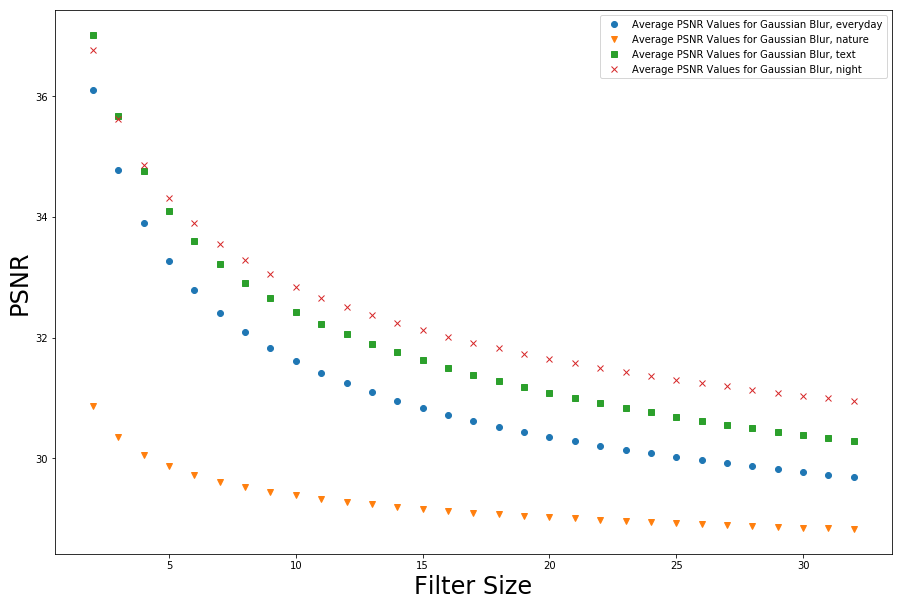

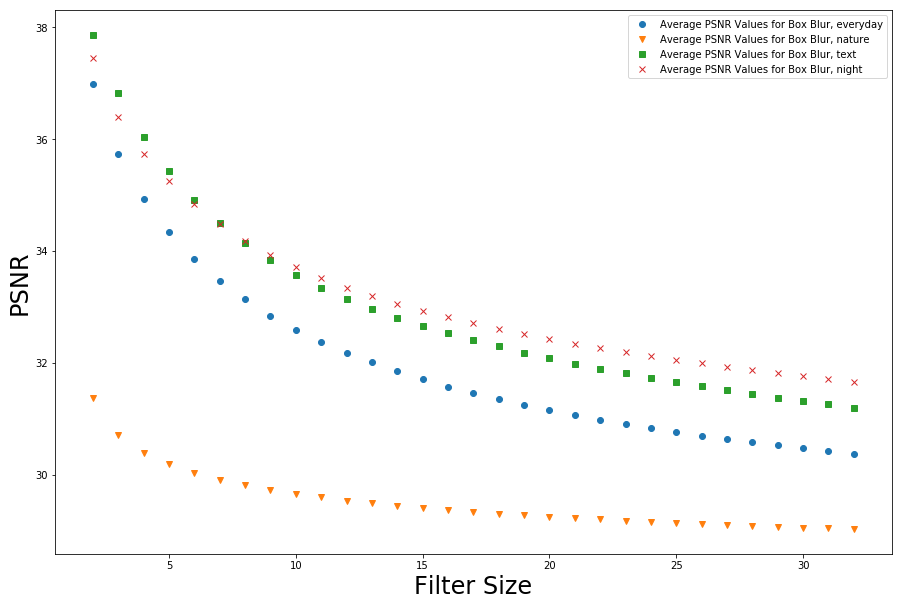

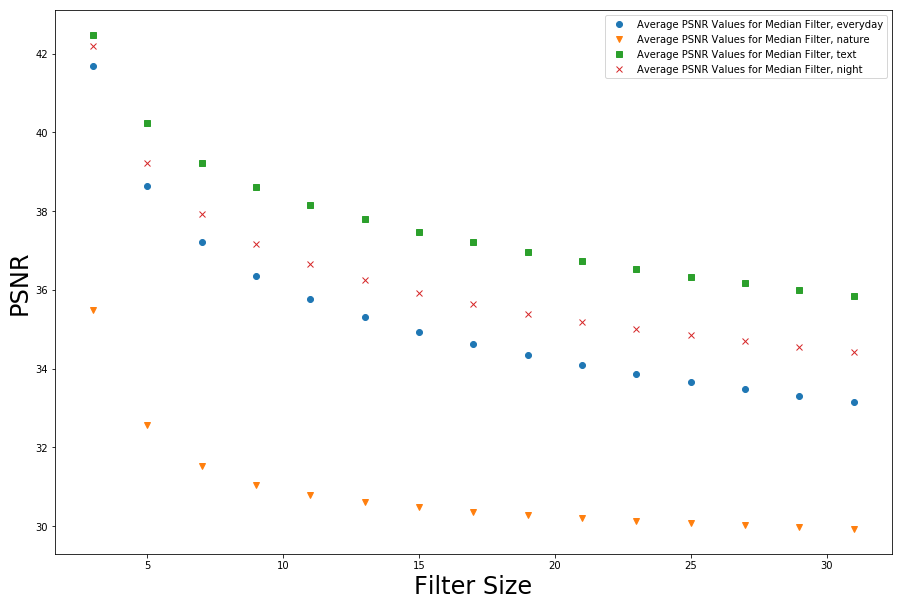

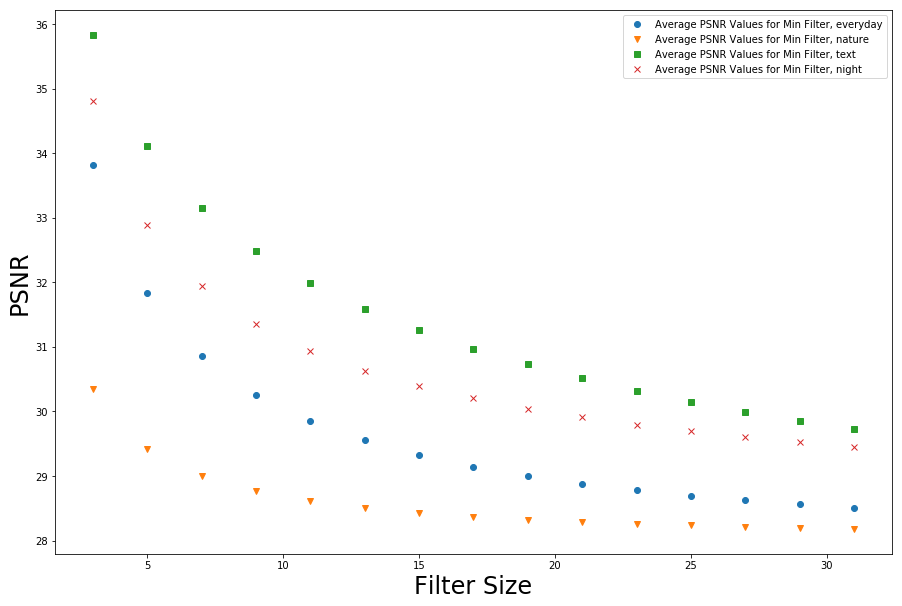

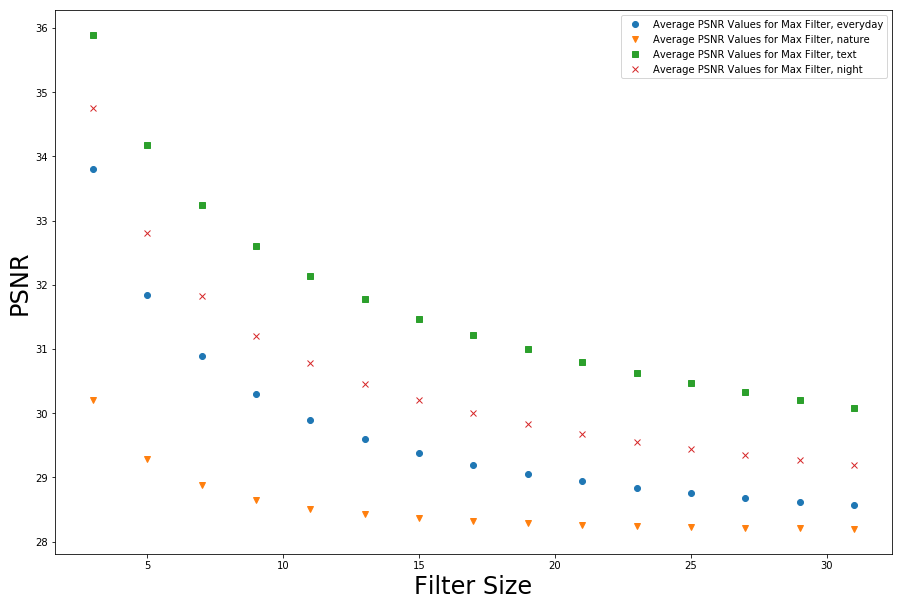

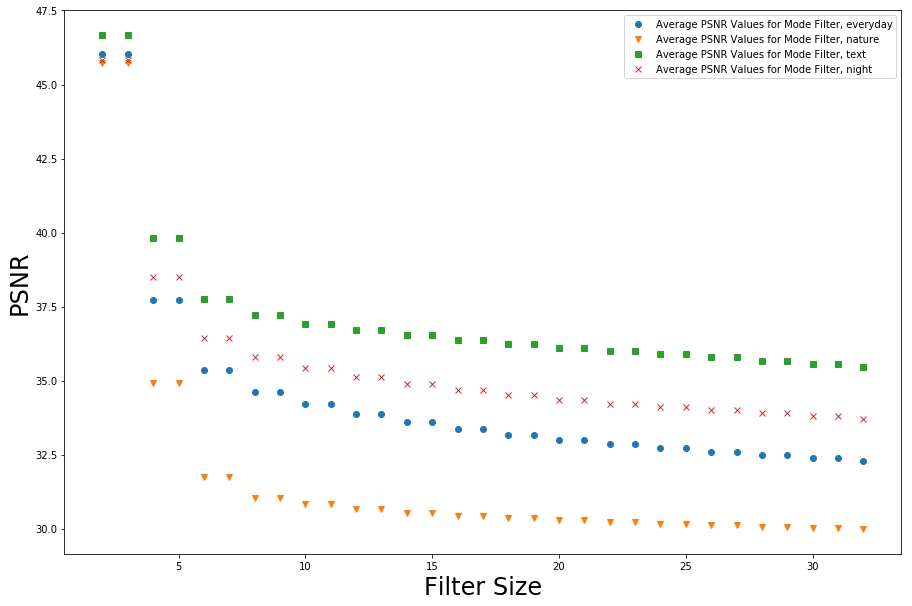

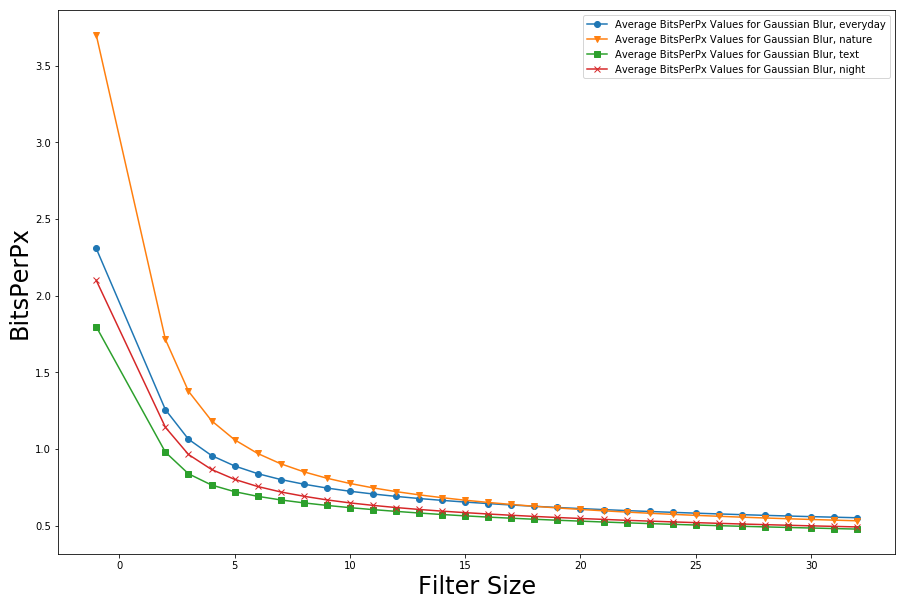

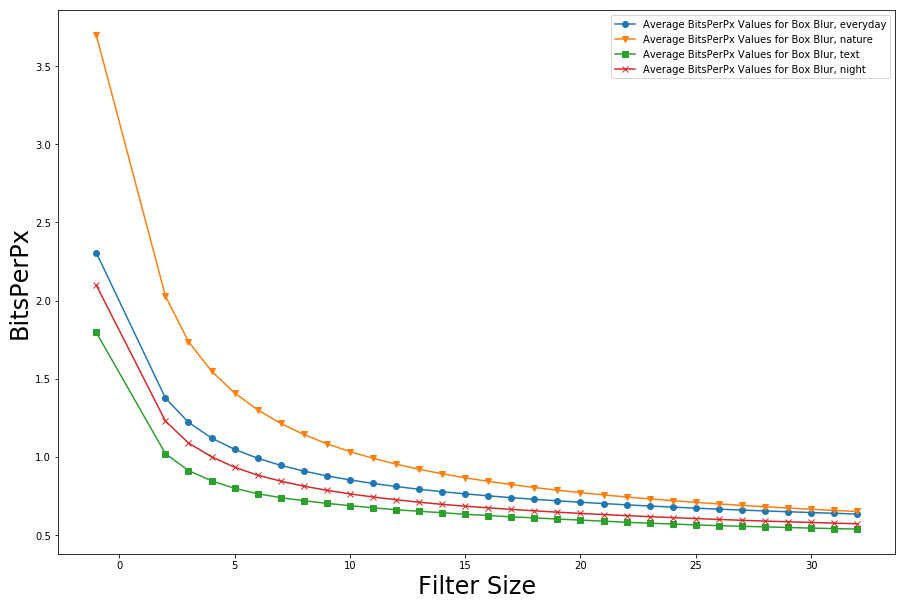

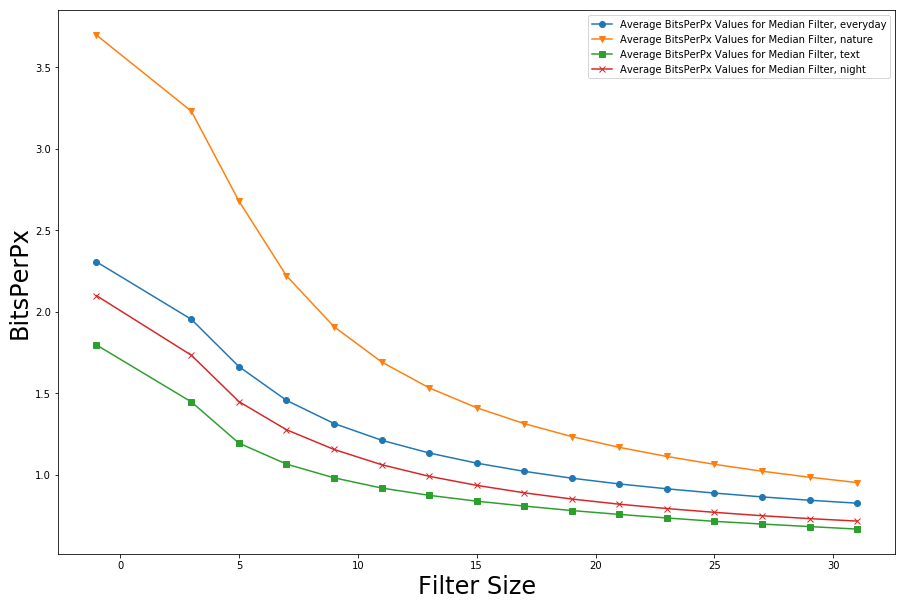

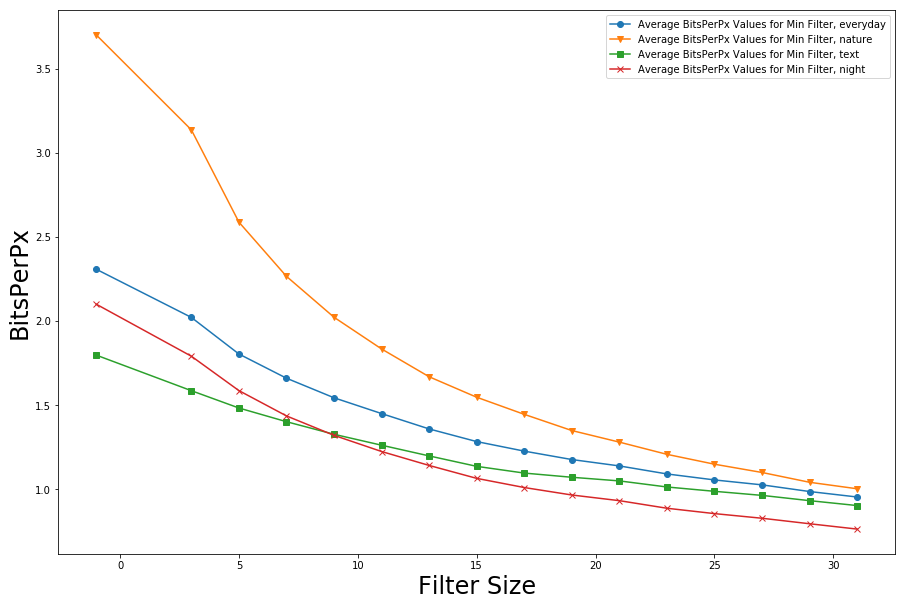

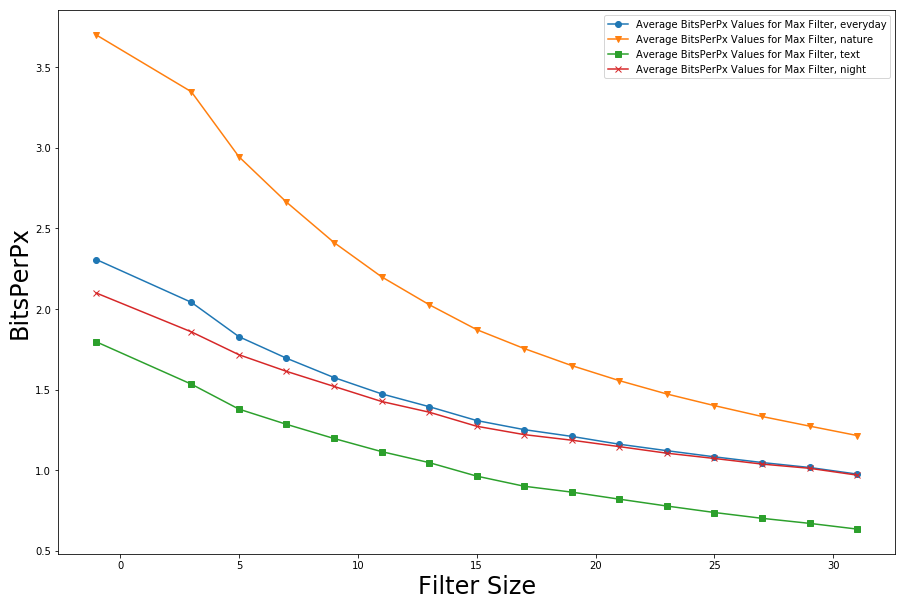

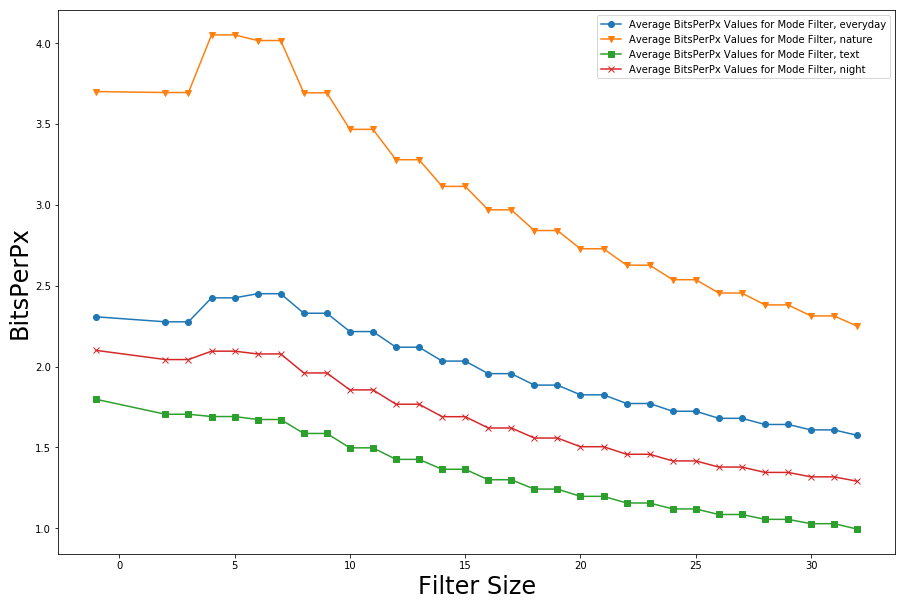

None -1
None -1
None -1
None -1


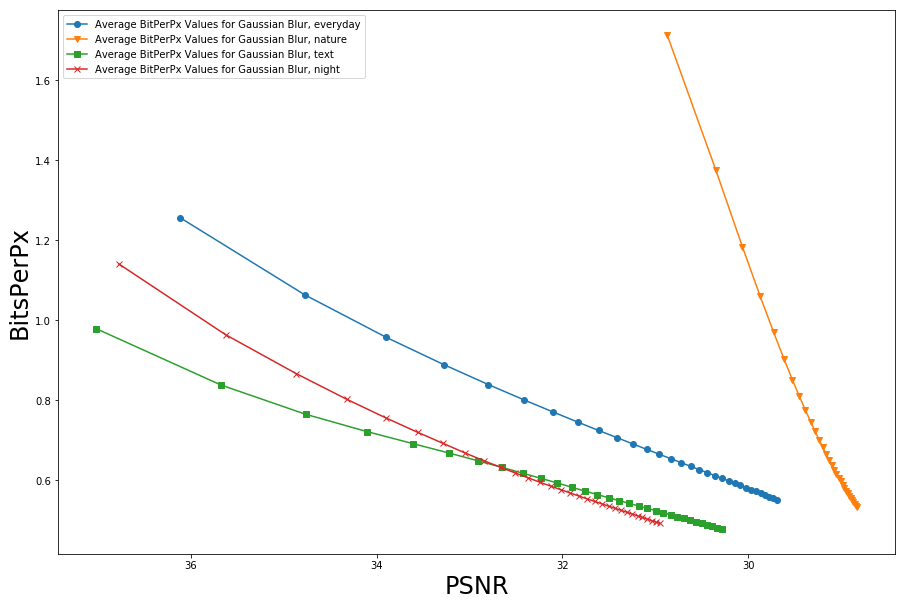

None -1
None -1
None -1
None -1


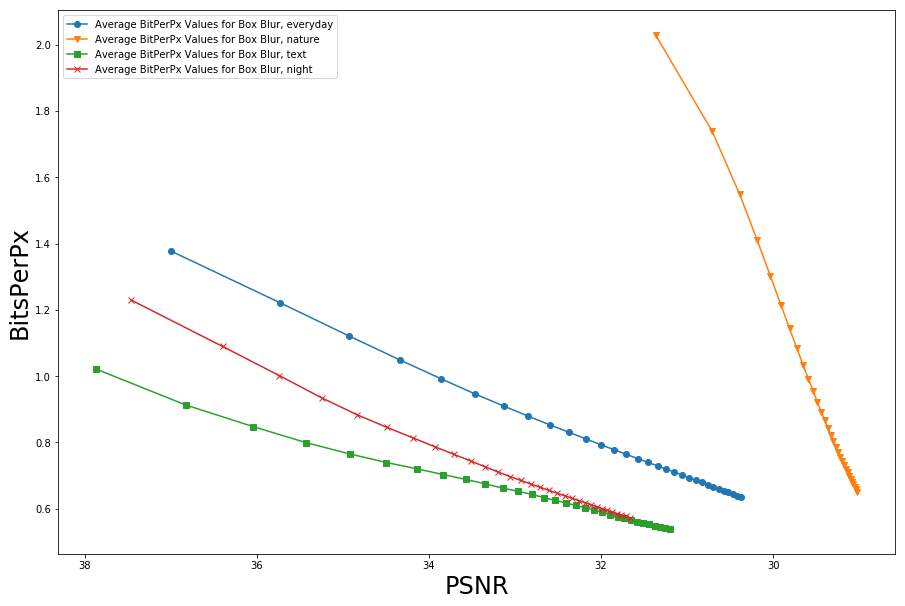

None -1
None -1
None -1
None -1


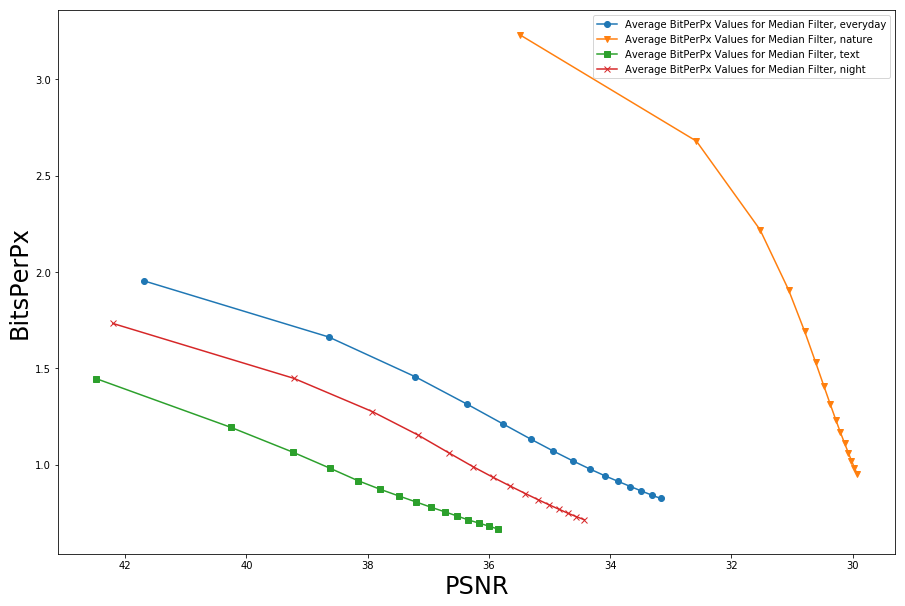

None -1
None -1
None -1
None -1


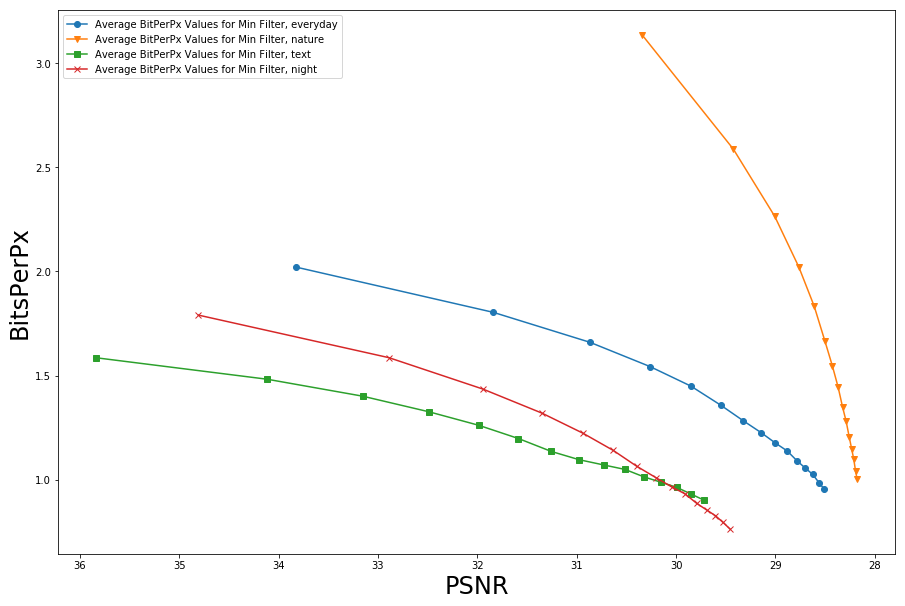

None -1
None -1
None -1
None -1


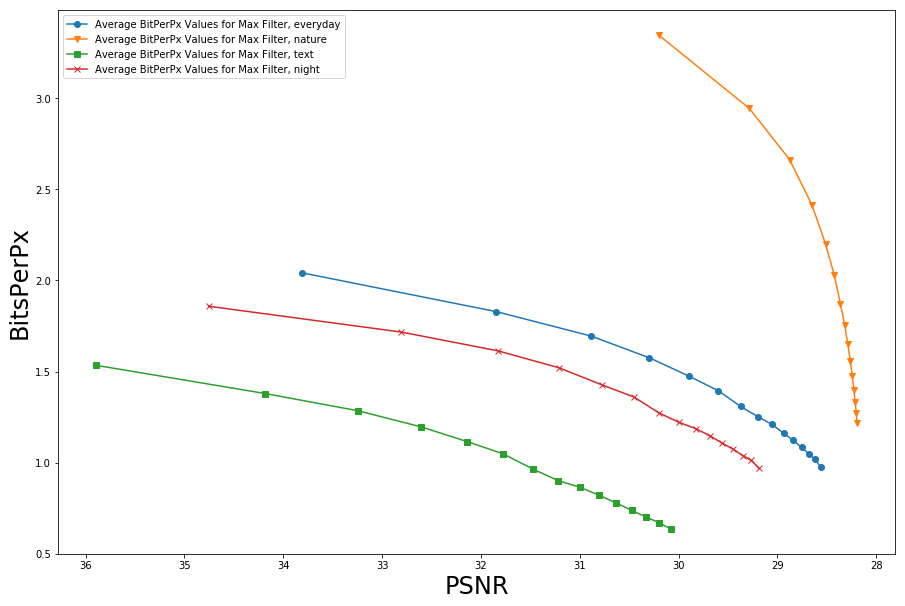

None -1
None -1
None -1
None -1


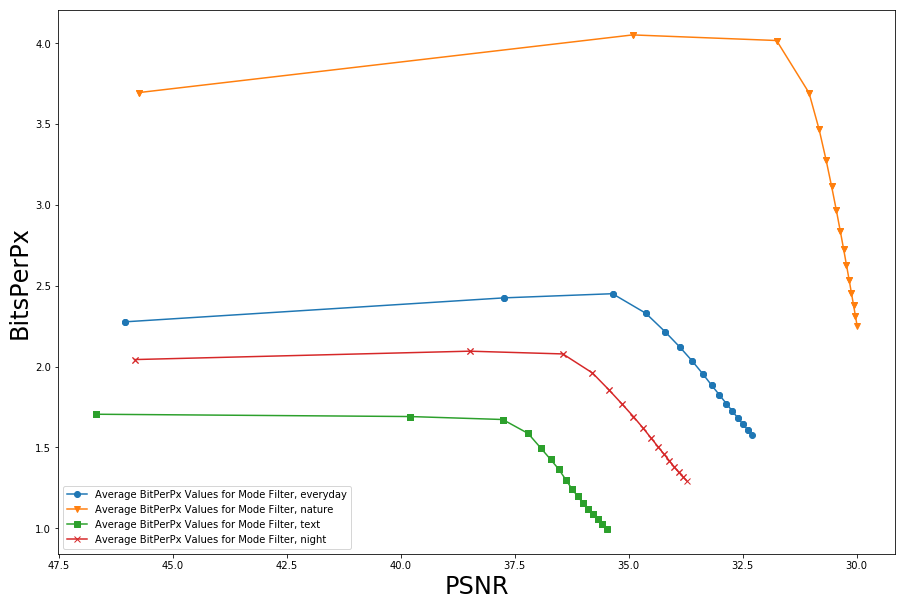

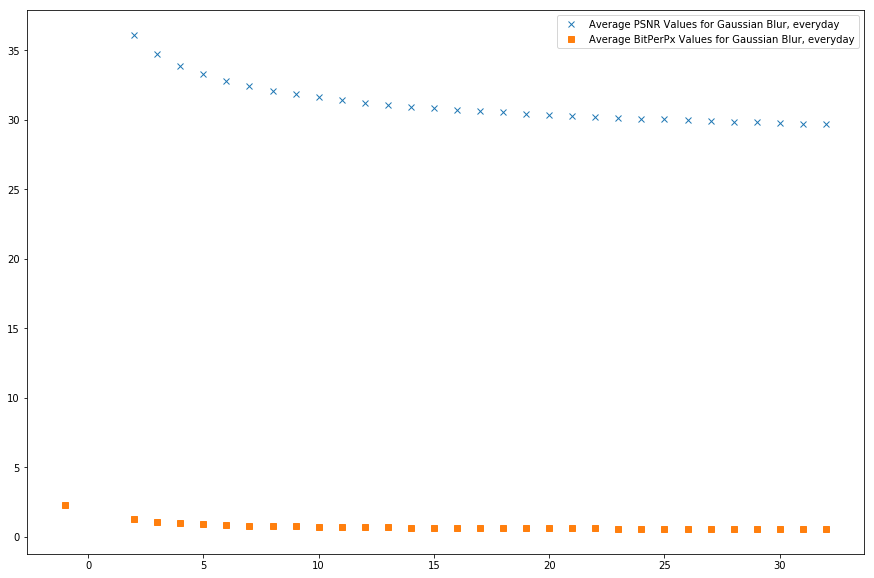

In [10]:
plt.rcParams['figure.figsize'] = [15, 10]

markers = 'o v s x D d | _'.split(' ')
i = 0
for (fil, cat), (sz, avg) in psnr_measures.items():
    plt.plot(sz, avg, ls='', marker=markers[i%4], label="Average PSNR Values for {}, {}".format(fil, cat))
    plt.xlabel("Filter Size", fontsize=24)
    plt.ylabel("PSNR", fontsize=24)
    i += 1
    plt.legend()
    if i % 4 == 0:
        plt.show()
plt.show()

i = 0
for (fil, cat), (sz, avg) in bpx_measures.items():
    plt.plot(sz, avg, marker=markers[i%4], label="Average BitsPerPx Values for {}, {}".format(fil, cat))
    plt.xlabel("Filter Size", fontsize=24)
    plt.ylabel("BitsPerPx", fontsize=24)
    i += 1
    plt.legend()
    if i % 4 == 0:
        plt.show()
plt.show()

i = 0
for (fil, cat) in bpx_measures.keys():
    sz, bavg = bpx_measures[(fil, cat)]
    ssz, pavg = psnr_measures[(fil, cat)]
    
    # validate lining up with right sizes
    # should only be None/-1 entries
    for s, ss in zip([None]+ssz, sz):
        if s != ss:
            print(s, ss)
    
    plt.plot([None] + pavg, bavg, marker=markers[i%4], label="Average BitPerPx Values for {}, {}".format(fil, cat))
    plt.xlabel("PSNR", fontsize=24)
    plt.ylabel("BitsPerPx", fontsize=24)
    i += 1
    plt.legend()
    if i % 4 == 0:
        plt.gca().invert_xaxis()
        plt.show()
plt.show()

egsz, egavg = psnr_measures[('Gaussian Blur', 'everyday')]
egbsz, egbavg = bpx_measures[('Gaussian Blur', 'everyday')]
plt.plot(egsz, egavg, ls='', marker='x', label='Average PSNR Values for Gaussian Blur, everyday')
plt.plot(egbsz, egbavg, ls='', marker='s', label='Average BitPerPx Values for Gaussian Blur, everyday')
plt.legend()
plt.show()